In [1]:
# import packages needed for entire model

import tensorflow as tf
from keras import layers, regularizers, metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import softsign
import shutil
import random
import sys
import h5py
from google.colab import drive
terminal = sys.stdout
# mount to google drive in order to pull data file
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Option 1 for running Network
# Takes Random Data of a specified size
subsetSize= 1000
validationSize = 2000
splicingVal = 11
numOutputs = int(220/splicingVal)

# import data file, splice data, split into testing and training data
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'][()])
z = list(zip(imgs, spectra, atfrac))
badIndices = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or np.sum(each) < 325 or round(np.sum(atfrac[i])) == 0]
badIndices.reverse()
for index in badIndices:
  del z[index]
random.shuffle(z)
imgs, spectra, atfrac = zip(*z)
imgs, spectra, atfrac  = np.array(imgs), np.array(spectra), np.array(atfrac)
spectra = np.array([x[::splicingVal] for x in spectra])
atfracNN = np.array(list(atfrac[0:subsetSize]))
imgsNN = np.array(list(imgs[0:subsetSize]))
spectraNN = np.array(list(spectra[0:subsetSize]))
atfrac_valid = np.array(list(atfrac[subsetSize:subsetSize+validationSize]))
x_valid = np.array(list(imgs[subsetSize:subsetSize+validationSize]))
y_valid = np.array(list(spectra[subsetSize:subsetSize+validationSize]))
del imgs, spectra, atfrac, z
#x_train, x_test, y_train, y_test = train_test_split(imgsNN, spectraNN, test_size = 0.2, random_state = None)

In [2]:
# Option 2 for running Network
# Takes a specified minimum amount of each element up to 1077

minAmount = 100 #Max is 1077
maxAmount = minAmount*3 #Must be greater than minAmount. Set to -1 to not use
validationSize = 2000
splicingVal = 11

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

# mount to google drive in order to pull data file
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'][()])
atfrac_keys = hf['atfrac_keys']
# import data file, splice data, split into testing and training data
z = list(zip(imgs, spectra, atfrac))
badIndices = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or np.sum(each) < 325 or round(np.sum(atfrac[i])) == 0]
badIndices.reverse()
for index in badIndices:
  del z[index]
random.shuffle(z)
imgs, spectra, atfrac = zip(*z)
imgs, spectra, atfrac  = np.array(imgs), np.array(spectra), np.array(atfrac)
spectra = [x[::splicingVal] for x in spectra]
numOutputs = int(220/splicingVal)
nonZeroList = [nonZeroInList(each) for each in atfrac]
oxideTracker = {}
indexListNN = []
indexList_valid = []

for i in range(len(atfrac)):
  oxideTracker[str(i)] = 0
for i, oxide in enumerate(nonZeroList):
  use = False
  overUsed = False
  for info in oxide:
    metal = info[1]
    if oxideTracker[str(metal)] < int(.75*minAmount):
      use = True
      break
    if maxAmount != -1 and oxideTracker[str(metal)] > maxAmount:
      use = False
      overUsed = True
    if oxideTracker[str(metal)] < minAmount and not overUsed:
      use = True
  if use:
    for info in oxide:
      metal = info[1]
      oxideTracker[str(metal)] += 1
    indexListNN.append(i)
  else:
    if len(indexList_valid) < validationSize:
      indexList_valid.append(i)
atfracNN, imgsNN, spectraNN, atfrac_valid, x_valid, y_valid = [], [], [], [], [], []
for index in indexListNN:
  atfracNN.append(atfrac[index])
  imgsNN.append(imgs[index])
  spectraNN.append(spectra[index])
for index in indexList_valid:
  atfrac_valid.append(atfrac[index])
  x_valid.append(imgs[index])
  y_valid.append(spectra[index])

atfracNN, imgsNN, spectraNN, atfrac_valid, x_valid, y_valid = np.array(atfracNN), np.array(imgsNN), np.array(spectraNN), np.array(atfrac_valid), np.array(x_valid), np.array(y_valid)
del imgs, spectra, atfrac, z, indexListNN, indexList_valid

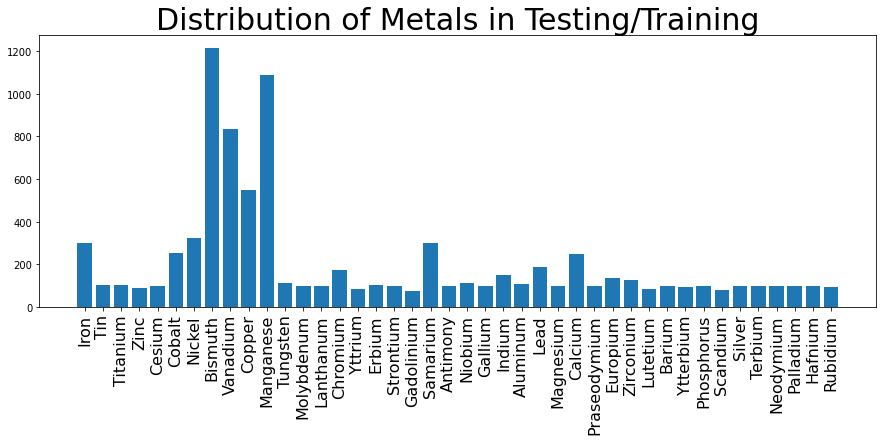

In [3]:
# Shows distribution based on what option you choose

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

nonZeroList = [nonZeroInList(each) for each in atfracNN]
dic = {}
for i in range(42):
  dic[str(i)] = 0
for nonZero in nonZeroList:
  for info in nonZero:
    metal = info[1]
    dic[str(metal)] += 1
#for i in range(42):
#  print(i, dic[str(i)])
f, axs = plt.subplots(figsize = (15,5))
oxides = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
oxides = oxides.split(', ') 
axs.bar(oxides, dic.values())
axs.set_xticklabels(oxides, rotation = 90, fontsize = 16)
axs.set_title('Distribution of Metals in Testing/Training', fontsize = 30)
plt.show()

0 21261
1 1508
2 1545
3 1541
4 7834
5 29479
6 29852
7 94303
8 70876
9 47566
10 94245
11 11303
12 8862
13 7798
14 8265
15 1575
16 5044
17 6256
18 3594
19 28389
20 5138
21 9454
22 4725
23 9993
24 4714
25 10988
26 4697
27 14921
28 4689
29 8698
30 3038
31 1983
32 3118
33 1573
34 3977
35 1398
36 2435
37 1077
38 3375
39 1565
40 1508
41 1457


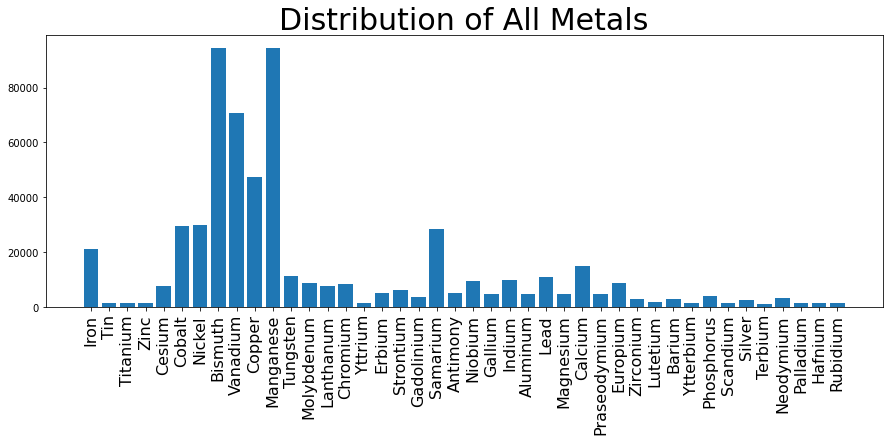

In [ ]:
# Distribution of all metals

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

atfrac = np.transpose(hf['atfrac'])
atfrac_keys = hf['atfrac_keys']

nonZeroList = [nonZeroInList(each) for each in atfrac]
dic = {}
for i in range(42):
  dic[str(i)] = 0
for nonZero in nonZeroList:
  for info in nonZero:
    metal = info[1]
    dic[str(metal)] += 1
for i in range(42):
  print(i, dic[str(i)])
f, axs = plt.subplots(figsize = (15,5))
oxides = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
oxides = oxides.split(', ') 
axs.bar(oxides, dic.values())
axs.set_xticklabels(oxides, rotation = 90, fontsize = 16)
axs.set_title('Distribution of All Metals', fontsize = 30)
plt.show()

In [ ]:
#Do not run. It's an experiment I have - Max
#x_train, x_test, y_train, y_test = train_test_split(imgs, spectra, test_size = 0.2, stratify = spectra)

array([2, 3])

In [4]:
# Current Neural Network Model function

def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = 'sigmoid')])
    model.summary()
    adamOpti = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(optimizer= adamOpti, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [5]:
# Running Neural Network with averaging Ensemble, including tensorboard and early stopping

# Define number of networks, batches, and epochs 

numNetworks = 10
epochs = 50
batch_size = 32
log_folder = 'logs'

# Run Neural Network for the desired number of networks in the ensemble (numNetworks)


modelList = []
historyList= []

data = ShuffleSplit(n_splits=numNetworks, random_state=0, test_size=0.20, train_size=None)
data.get_n_splits(imgsNN, spectraNN)
for train_index, test_index in data.split(imgsNN, spectraNN):
  x_train, x_test = imgsNN[train_index], imgsNN[test_index]
  y_train, y_test = spectraNN[train_index], spectraNN[test_index]
  normal_model = get_conv_model_normal()
  sys.stdout = terminal
  normal_model.summary()
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1,
                callbacks= [early_stopping])
  modelList.append(normal_model)
  historyList.append(normal_history)


# Create predictions based on results of the neural network and ensemble 

def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]

# Create the geometric average of the output spectra from the predicted values from the ensemble

def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

# Create the arithmetic average of the output spectra from the predicted values from the ensemble, commented out for now for simplicity

# def ensemblePredictArithAverage(predictList, ele):
#  numNetworks = len(predictList)
#  prediction = 0
#  for predict in predictList:
#    prediction += predict[ele]
#  return prediction/numNetworks

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 dense (Dense)               (None, 62, 62, 256)       16640     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               62980352  
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
69/69 [==============================] - 17s 45ms/step - loss: 0.0777 - mean_squared_error: 0.0777 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 2/50
69/69 [==============================] - 3s 38ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.0692 - val_mean_squared_error: 0.0692
Epoch 3/50
69/69 [==============================] - 3s 38ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 4/50
69/69 [==============================] - 3s 38ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 5/50
69/69 [==============================] - 3s 38ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 0.0659 - val_mean_squared_error: 0.0659
Epoch 6/50
69/69 [==============================] - 3s 39ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 0.0657 - val_mean_squared_error: 0.0657
Model: "sequential_1"
___________

In [ ]:
# to get individual layer weights

#model = modelList[0]
#for layer in model.layers:
    #print(f'{layer.name}, {layer.weights}')

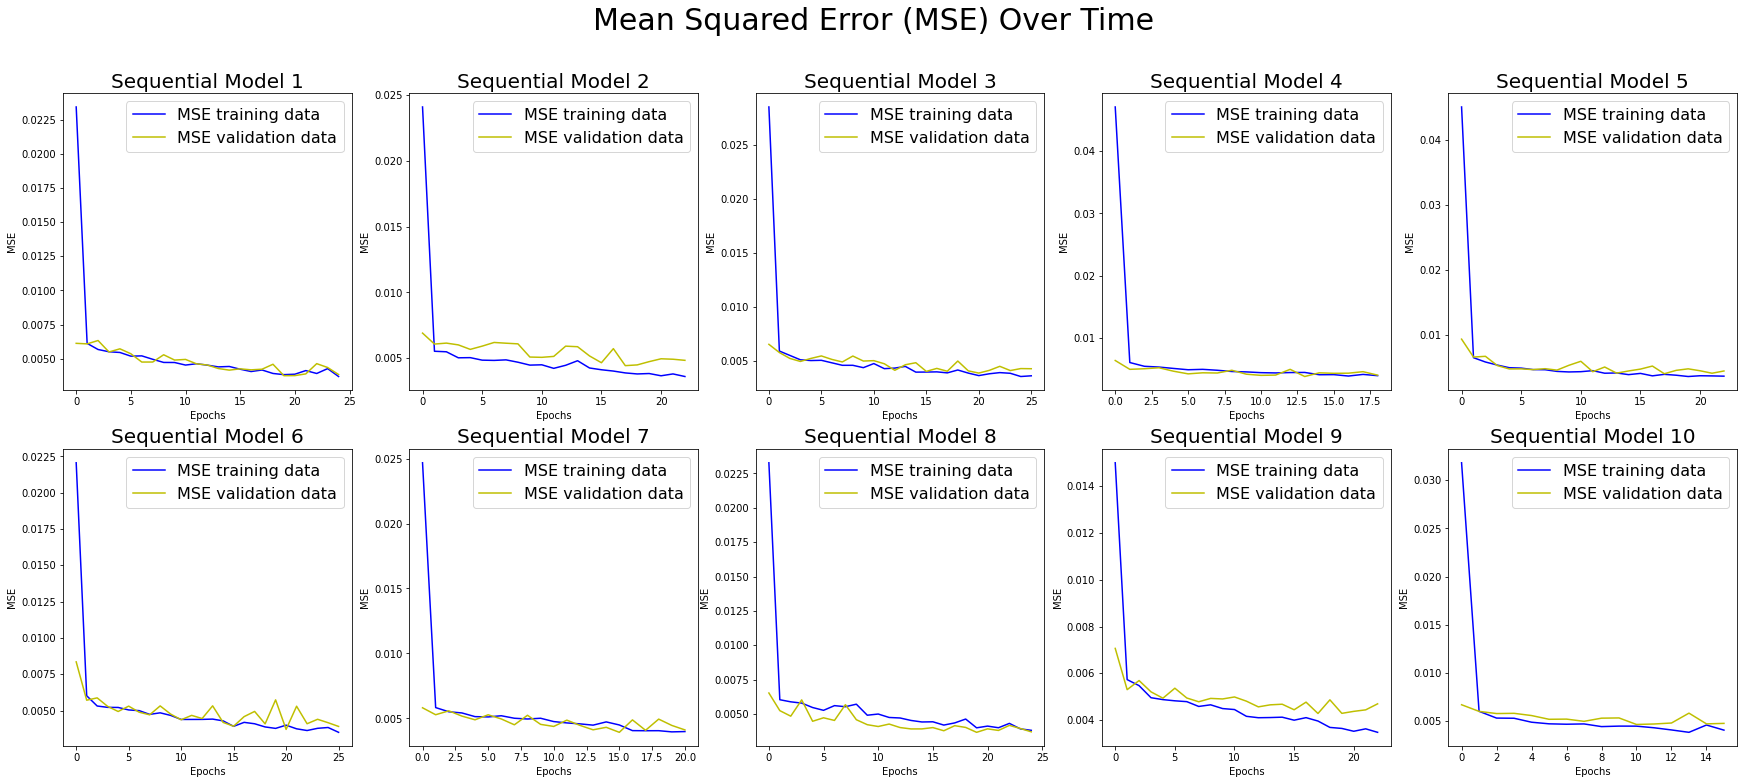

In [ ]:
# Get MSE Plot

from IPython.core.pylabtools import figsize
def closest_factor(num):
  n = int(np.ceil(np.sqrt(num)))
  if num % n == 0:
    return n, n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

low, high = closest_factor(numNetworks)
fig = plt.figure(1, figsize = (6*high,6*low))
plt.title('Mean Squared Error (MSE) Over Time', fontsize = 30)
for i in range(low):
  for j in range(high):
    index = high*i + j
    y = historyList[index].history
    plt.subplot(low, high, index+1)
    plt.plot(y['mean_squared_error'], color = 'b')
    plt.plot(y['val_mean_squared_error'], color = 'y')
    plt.legend(['MSE training data', 'MSE validation data'], prop={'size': 16})
    plt.title(f'Sequential Model {index+1}', fontsize = 20)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
fig.suptitle('Mean Squared Error (MSE) Over Time', fontsize = 30)

plt.savefig('MSE_Plot.jpg')

63/63 [==============================] - 1s 9ms/step


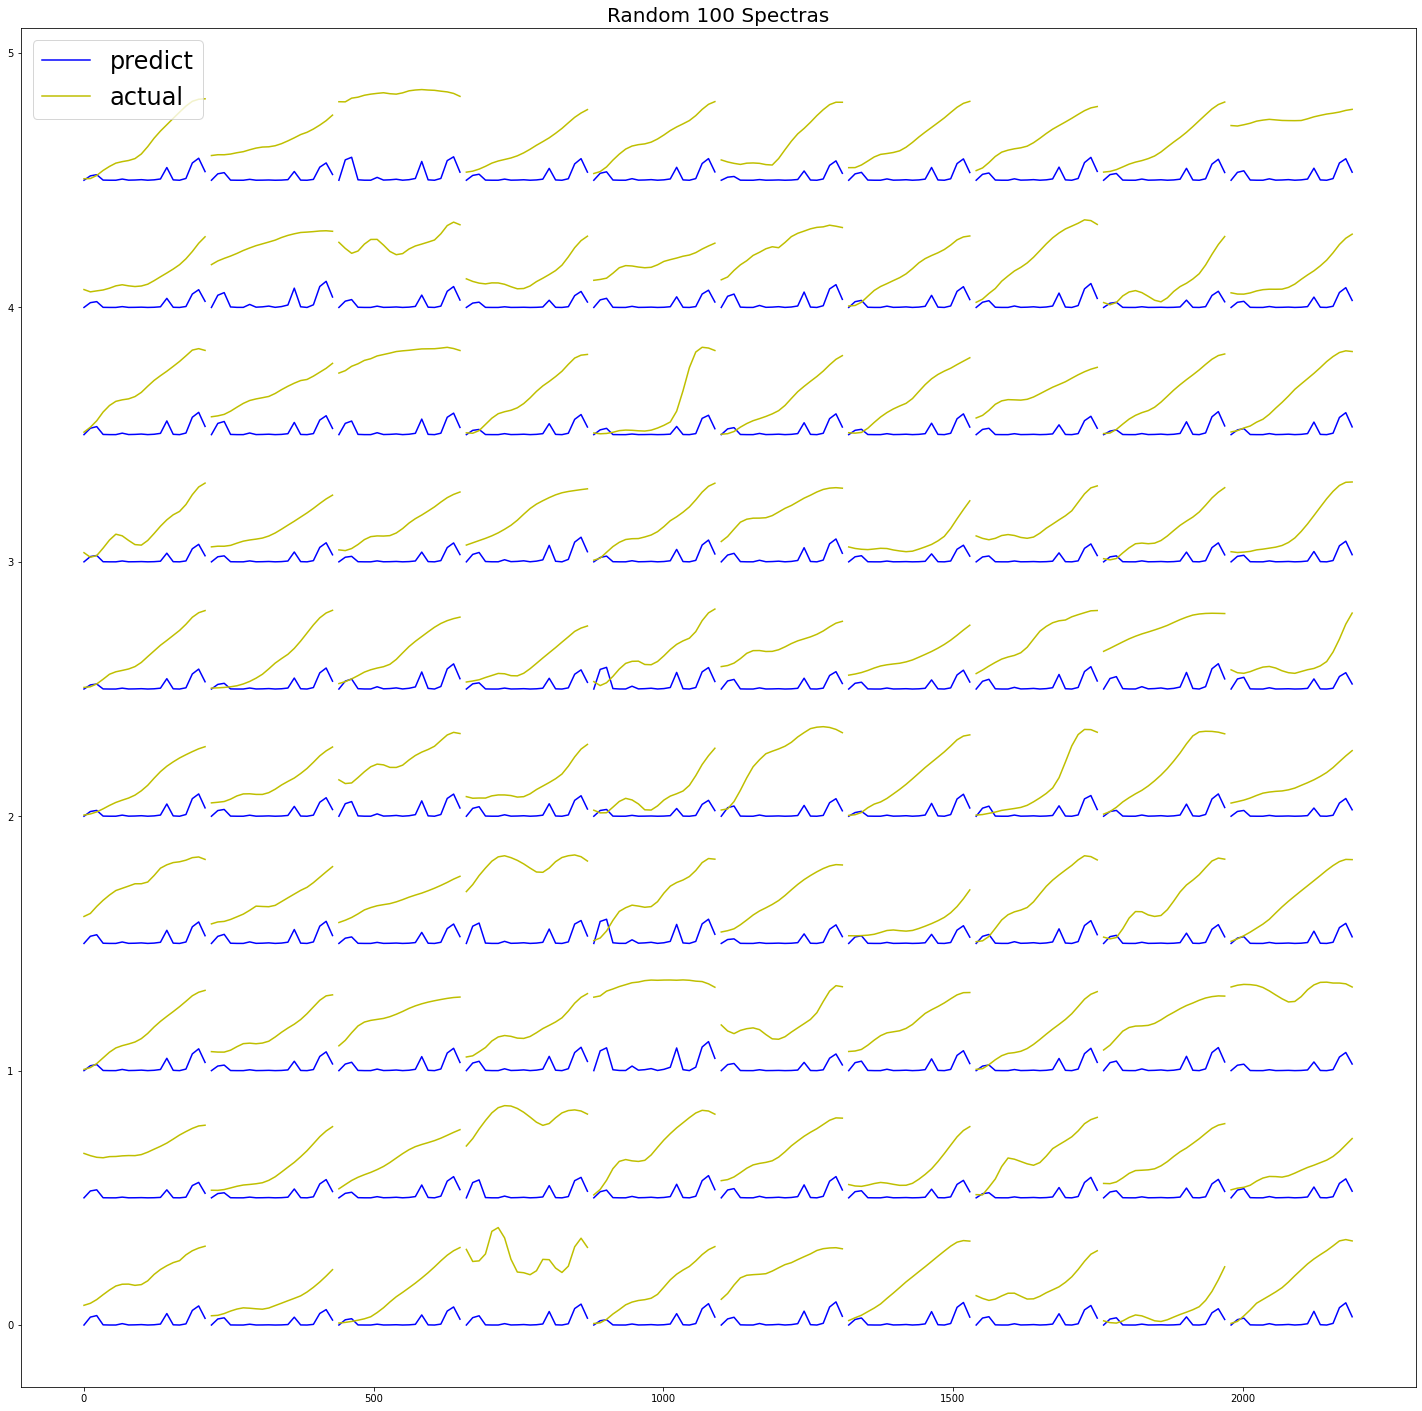

In [6]:
# Creates Random 100 Grid of Spectras from Validation Data

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
rando = [x for x in range(len(y))]
random.shuffle(rando)
fig = plt.figure(figsize=(25, 25))
for j in range(10):
  for i in range(10):
    rand = rando[10*j + i]
    plt.plot(x + 220*i, y[rand]+.5*j, color = 'b')
    plt.plot(x + 220*i, y_valid[rand]+.5*j, color = 'y')
    i+=1
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Random 100 Spectras', fontsize = 20)
plt.savefig('Random100Grid.jpg')
plt.show()

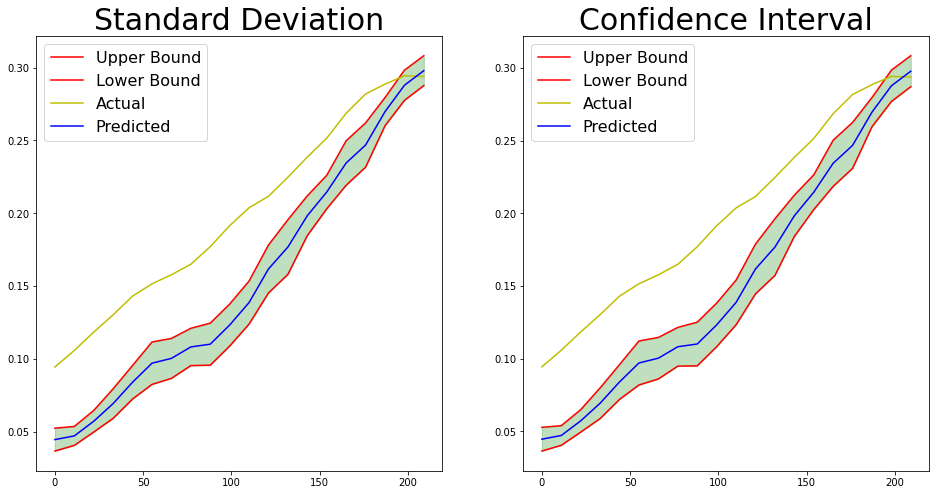

In [ ]:
# Show the confidence interval on the ensemble average prediction
CI = {
'95%': 1.96,
 '99%': 2.576,
 '99.5%': 2.807,
 '99.9%': 3.291
}
def ensembleUncertainty(predictList, ele):
  newPredict = np.transpose(predictList, (1, 2, 0))
  return np.array([np.std(output) for output in newPredict[ele]])

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])

fig, ax = plt.subplots(1, len(CI), figsize=(16, 8))

i = 0
axIter = 0
for perc, val in CI.items():
# Plot lines
  topUQ = y[i]+val*(UQ[i]/np.sqrt(numNetworks))
  botUQ = y[i]-val*(UQ[i]/np.sqrt(numNetworks))
  ax[axIter].plot(x, topUQ, color="red")
  ax[axIter].plot(x, botUQ, color="red")

  # Fill area when income > expenses with green
  ax[axIter].fill_between(
      x, topUQ, botUQ, where=(topUQ > botUQ), 
      interpolate=True, color="green", alpha=0.25, 
      label="Positive"
  )

  ax[axIter].plot(x, y_valid[i], color = 'y')
  ax[axIter].plot(x, y[i], color="blue")
  ax[axIter].set_title(f'{perc} Confidence Interval', fontsize = 30)
  ax[axIter].legend(['Upper Bound', 'Lower Bound', 'Actual', 'Predicted'], fontsize = 16)
  axIter += 1
fig.savefig('Confidence.jpg')

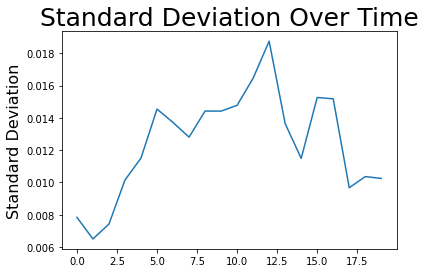

In [ ]:
# ONLY RUN IF NEEDED
# Shows graph of how standard deviation changes over the model

x = np.array([x for x in range(0,220,splicingVal)])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
plt.plot(UQ[i])
plt.title('Standard Deviation Over Time', fontsize = 25)
plt.ylabel('Standard Deviation', fontsize = 16)

plt.savefig('SDGraph.jpg')

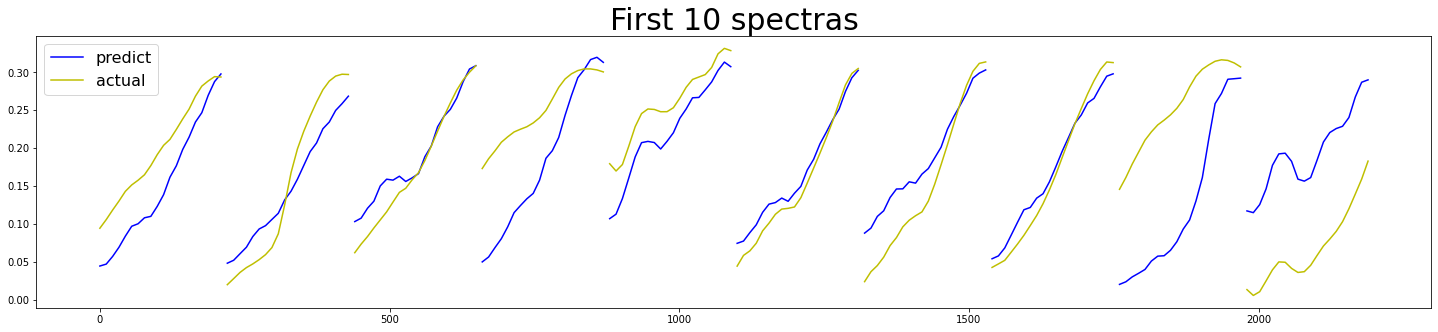

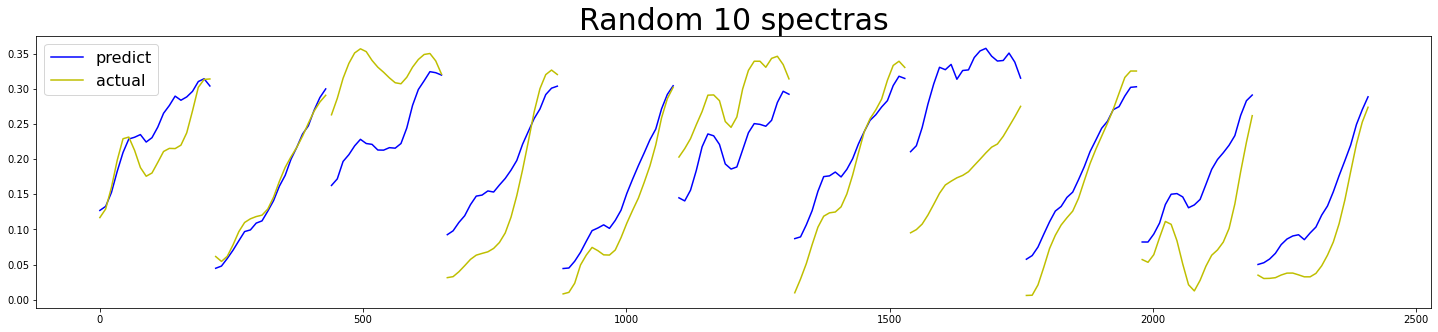

In [ ]:
# DO NOT RUN UNLESS NEEDED - not that important anymore and 100 random is better representation
# Plots first 10 spectra images on a single graph

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x + 220*i, y[i] , color = 'b')
  plt.plot(x + 220*i, y_valid[i], color = 'y')
  plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 16})
plt.title('First 10 spectras', fontsize = 30)
plt.savefig('First10.jpg')
plt.show()

# Plots random 10 spectra images on a single graph

rando = [x for x in range(10, len(y))]
random.shuffle(rando)
i = 0
fig = plt.figure(figsize=(25, 5))
for rand in rando:
  if i > 10:
    break
  plt.plot(x + 220*i, y[rand], color = 'b')
  plt.plot(x + 220*i, y_valid[rand], color = 'y')
  plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 16})
  i+=1
plt.title('Random 10 spectras', fontsize = 30)

plt.savefig('Random10.jpg')
plt.show()

IndexError: ignored

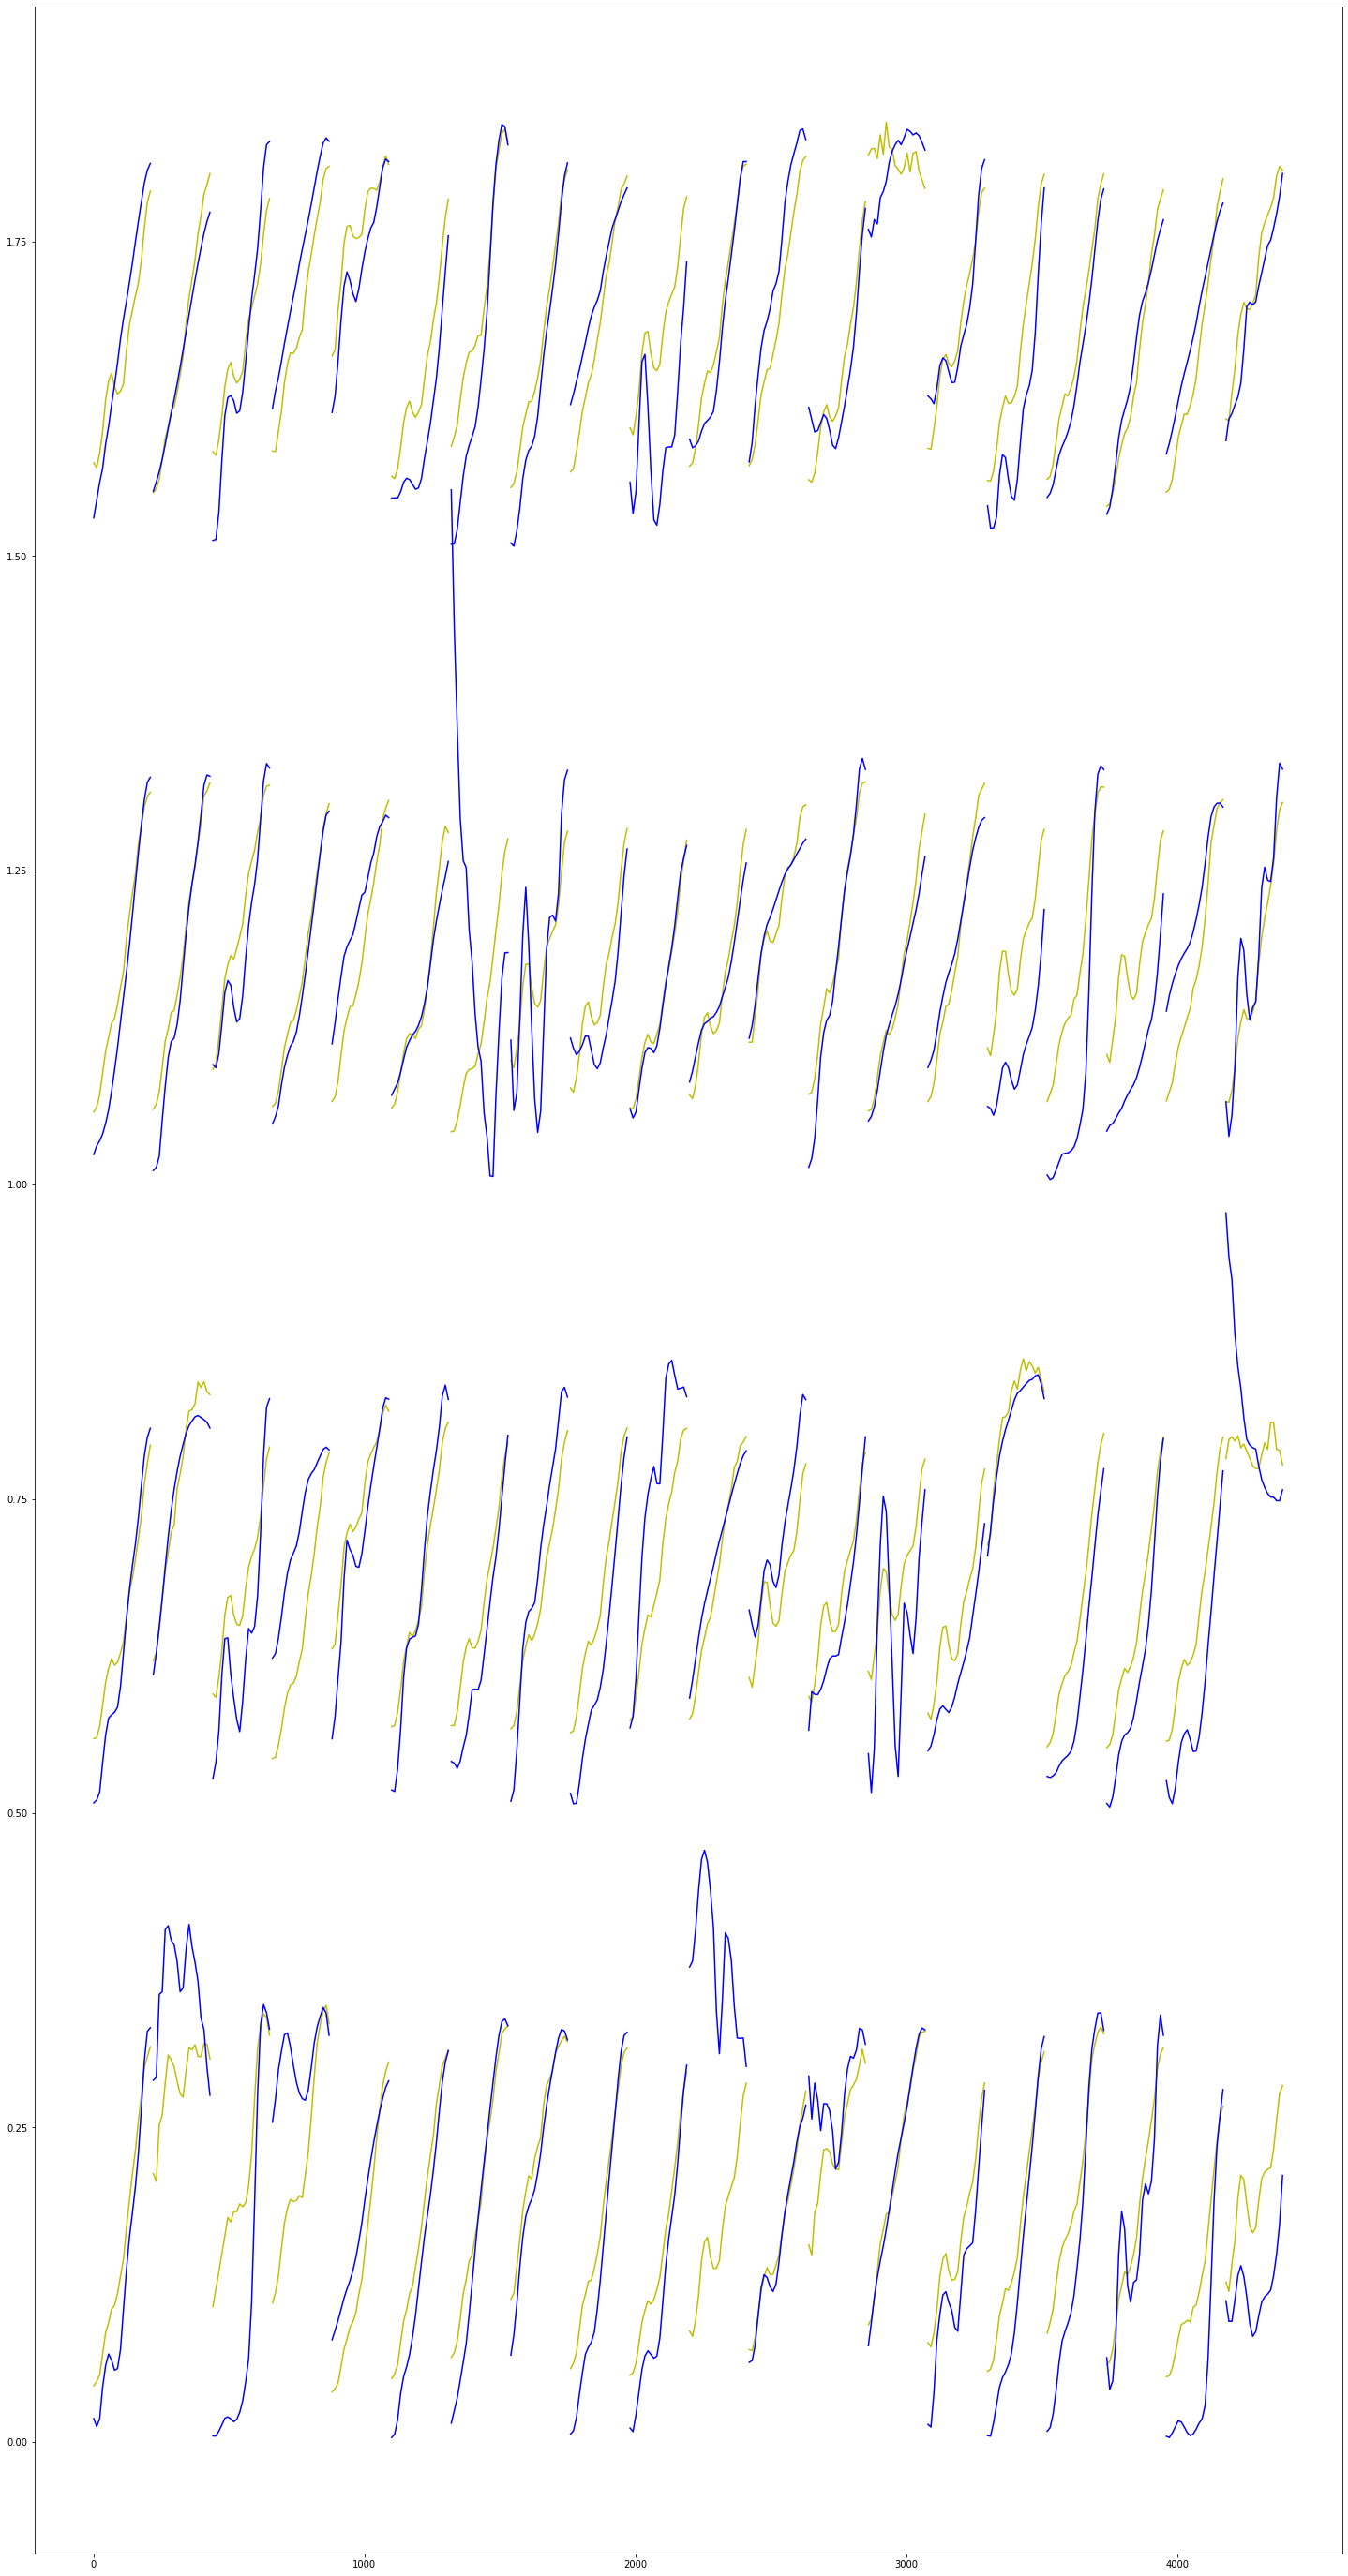

In [ ]:
# DO NOT RUN UNLESS NEEDED - not visually easy on the eyes and 100 random is better
# Creates Grid of All Spectras in Testing set

def closest_factor(num):
  n = int(np.sqrt(num))
  if num % n == 0:
    return n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_test)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]
fig = plt.figure(figsize=(25, 50))
low, high = closest_factor(len(x_test))
for j in range(low):
  for i in range(high):
    plt.plot(x + 220*i, y[50*j+i]+.5*j, color = 'y')
    plt.plot(x + 220*i, y_test[50*j+i]+.5*j, color = 'b')
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Each Individual Spectra', fontsize = 30)
plt.savefig('EverySpectra.jpg')
plt.show()

63/63 [==============================] - 1s 9ms/step


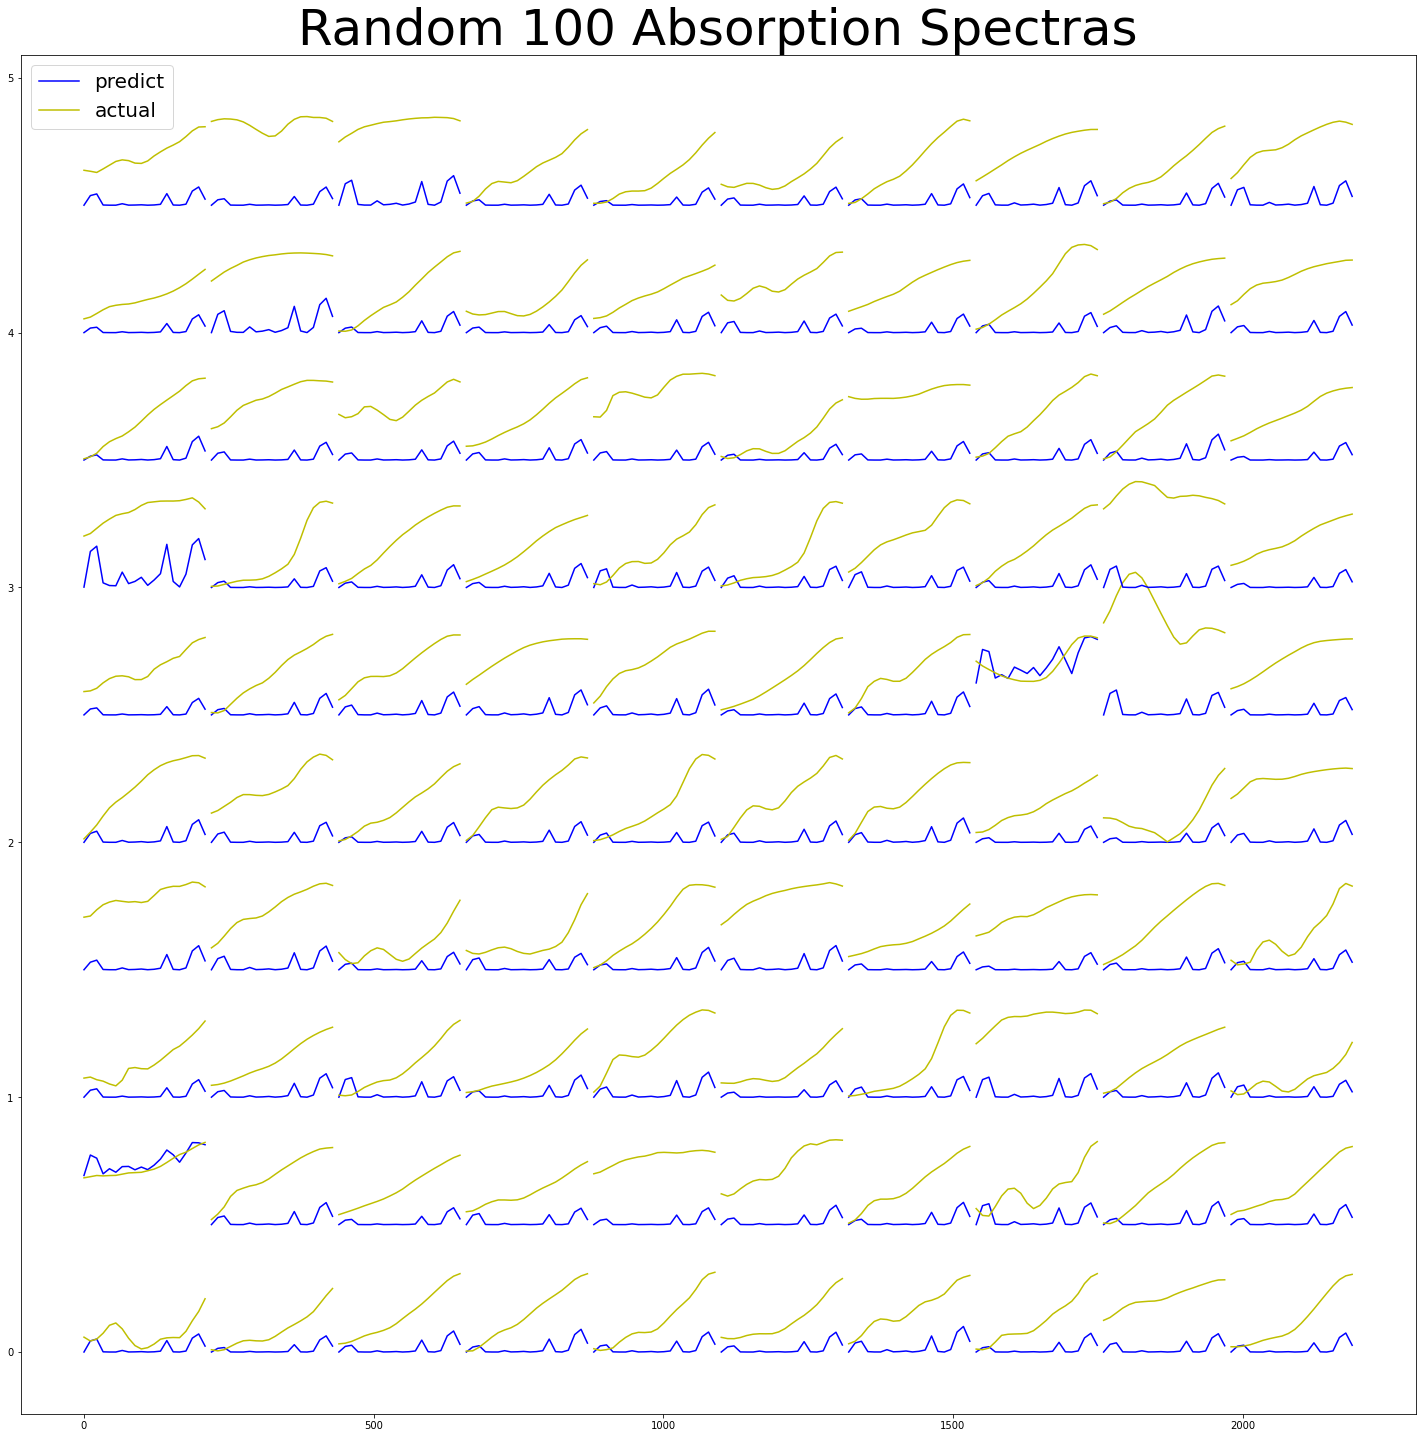

In [7]:
# Creates Random 100 Grid of Spectras from Validation Data

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
rando = [x for x in range(len(y))]
random.shuffle(rando)
fig = plt.figure(figsize=(25, 25))
for j in range(10):
  for i in range(10):
    rand = rando[10*j + i]
    plt.plot(x + 220*i, y[rand]+.5*j, color = 'b')
    plt.plot(x + 220*i, y_valid[rand]+.5*j, color = 'y')
    i+=1
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 20})
plt.title('Random 100 Absorption Spectras', fontsize = 50)
plt.savefig('Random100Grid.jpg')
plt.show()

In [ ]:
#Histogram - DO NOT USE CAUSES SESSION TO CRASH

predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
y_valid = np.array(y_valid)
fig = plt.figure(figsize=(10, 5))
#n, bins, patches = plt.hist((y_pred-y_valid)/y_valid, bins=100)
y=100*(y_pred-y_valid)/y_valid
y = np.array(y).flatten()
plt.hist(y, bins=500)

for spectra in y:
  plt.plot(y, 'o')

plt.xlabel('Percent Error', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title('Percent Error', fontsize=20)

plt.show()
fig.savefig('Histogram.jpg')

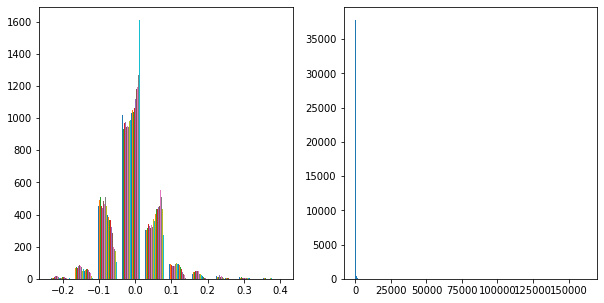

In [ ]:
#Histogram
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
y_valid = np.array(y_valid)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].hist(y_valid - y_pred)

#n, bins, patches = plt.hist((y_pred-y_valid)/y_valid, bins=100)
y=100*(y_pred-y_valid)/y_valid
y = np.array(y).flatten()
plt.hist(y, bins=500)
#for spectra in y:
#  plt.plot(y, 'o')
#plt.show()
#plt.xlabel('Percent Error', fontsize=12)
#plt.ylabel('', fontsize=12)
#plt.title('Percent Error', fontsize=20)
fig.savefig('Histogram.jpg')

In [ ]:
# Make Scatterplot Error graph with GEOMETRIC MEAN, blue is all networks, yellow is average
# Still need to figure out how to get R^2 value for individual networks

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(15, 15), dpi=300)
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.5, color = 'y', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.5, color = 'b', label = 'Ensemble Network')
a, b = 0, .7 
plt.axis([0, .8, 0, .8])
plt.plot([a,b],[a,b], color='black')
plt.title('Scatter Plot Error', fontsize = 30)
plt.xlabel('y actual', fontsize = 20)
plt.ylabel('y predicted', fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 20}
axe.text(.05, 0.75, f" Ensemble Network R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
# axe.text(.1, 0.75, f"Individual Networks R^2 = {round(r2_score(np.array(predictList), np.array(y_valid*5).flatten()))}", fontdict = font)
plt.savefig('SymErrorGeo.jpg')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

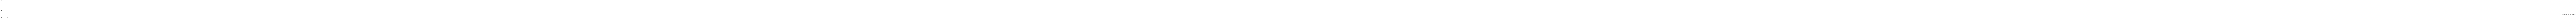

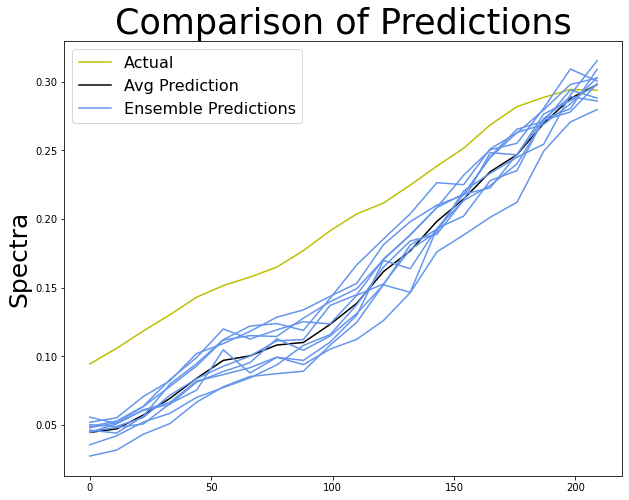

In [ ]:
# Create comparison graph of the actual spectra (blue), each networks predicted spectra (yellow), and the final averaged prediction (black)

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(x_valid[0])
axs[1].plot(x, y_valid[0], color = 'y')
axs[1].plot(x,y_pred[0], color = 'black')
for predict in predictList:
  axs[1].plot(x, predict[0], color = 'cornflowerblue')
axs[1].legend(['Actual', 'Avg Prediction', 'Ensemble Predictions'], loc = 'upper left', prop={'size': 16})
#plt.ylabel('Spectra', fontsize = 25)
axs[1].text(100, 0.15, f" Ensemble Network MSE = {round(float(np.mean((y_pred - y_valid)**2)), 5)}")
axs[1].text(100, 0.12, f" Single Network MSE = {round(float(np.mean((predictList[0] - y_valid)**2)), 5)}")
fig.suptitle('Comparison of Predictions', fontsize = 35)
plt.show()
plt.savefig('PredictCompare.jpg')

Accuracy = 0.148025
Total MSE = 0.0033778264187276363


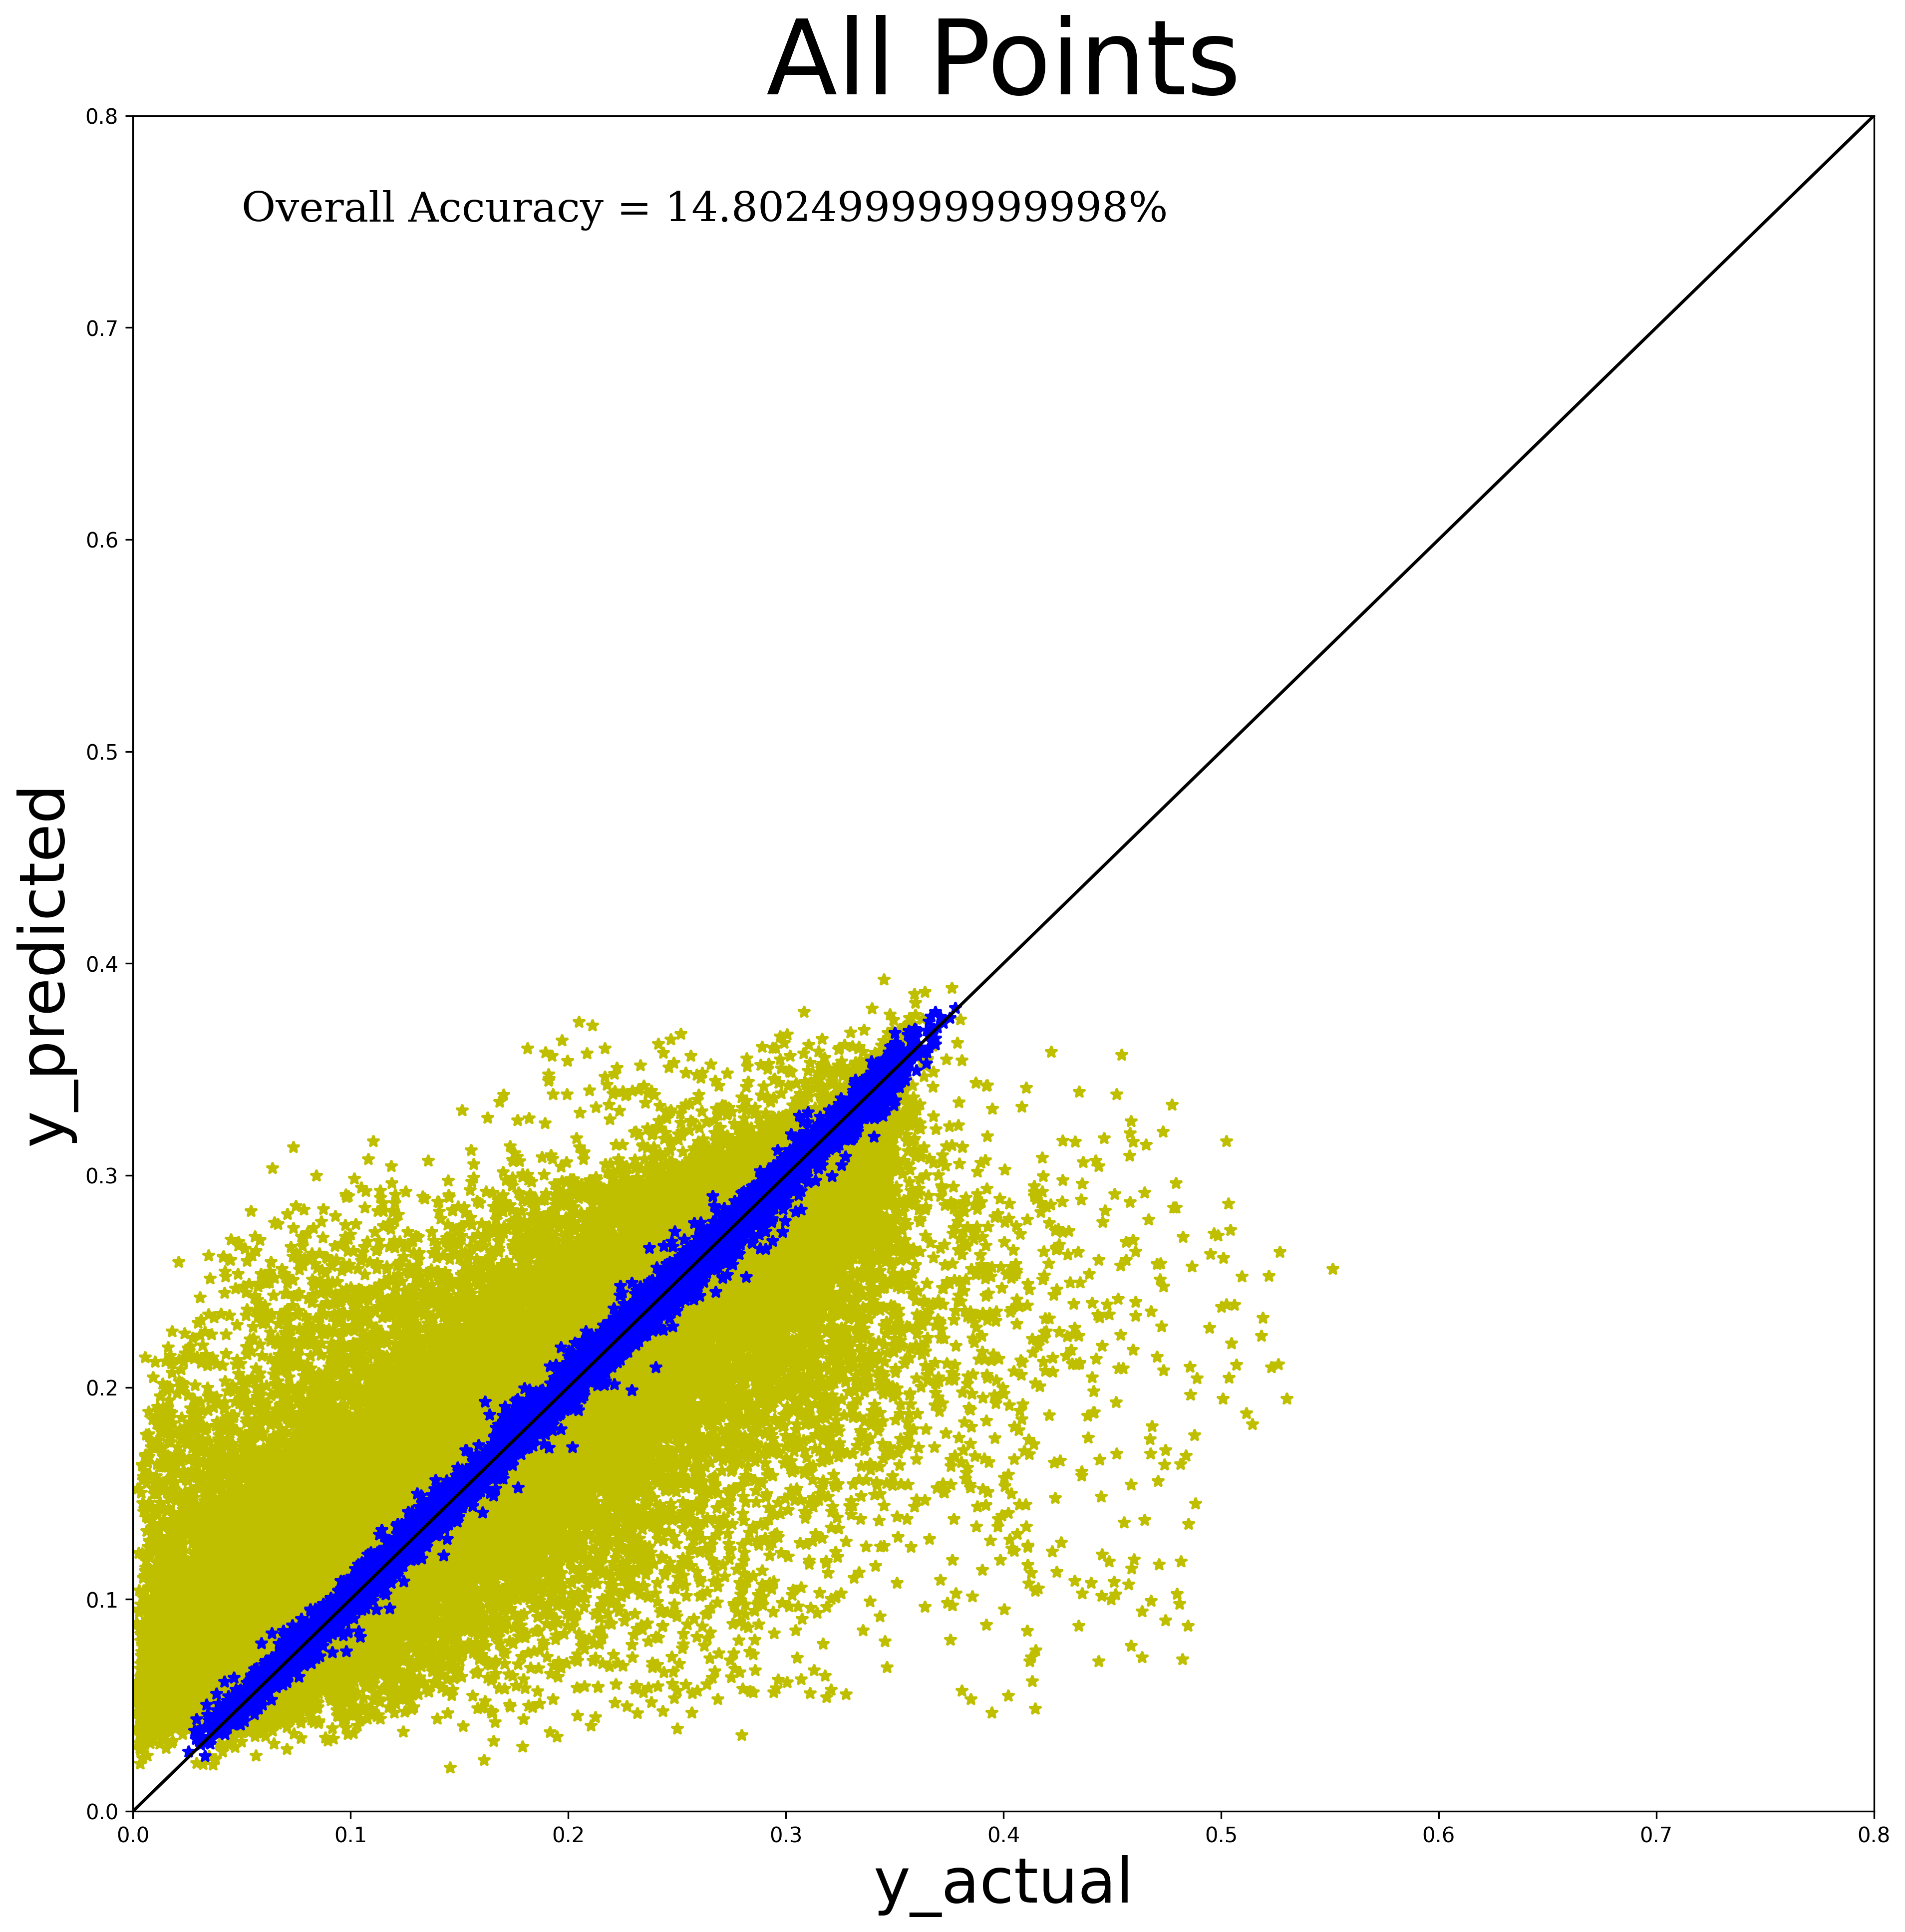

In [ ]:
# Must run confidence interval block for this to run
# accuracy thingy majig
# need to fix and make one plot

y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
goodX, goodY = [], []
badX, badY = [], []
for i, spectra in enumerate(np.abs(y_pred - y_valid)):
  for j, ele in enumerate(spectra):
    if ele < UQ[i][j]*1.96/np.sqrt(numNetworks):
      goodY.append(y_pred[i][j])
      goodX.append(y_valid[i][j])
    else:
      badY.append(y_pred[i][j])
      badX.append(y_valid[i][j])
print(f'Accuracy = {len(goodX)/(20*len(x_valid))}')
print(f'Total MSE = {np.mean((y_valid-y_pred)**2)}')
fig, ax = plt.subplots(1, figsize = (15,15), dpi=300)
plt.axis([0, .8, 0, .8])


ax.plot(badX, badY, '*', color = 'y')
ax.plot(goodX, goodY, '*', color = 'b')
a, b = 0, .8
ax.plot([a,b],[a,b], color='black')
ax.set_title('All Points', fontsize = 50)
ax.set_xlabel('y_actual', fontsize = 30)
ax.set_ylabel('y_predicted', fontsize = 30)

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 20}
ax.text(0.05, 0.75, f"Overall Accuracy = {(len(goodX)/(20*len(x_valid)))*100}%", fontdict = font)


#ax[1].plot(badX, badY, '*', color = 'y')
#a, b = 0, .4 
#ax[1].plot([a,b],[a,b], color='black')
#ax[1].set_title('Bad Points', fontsize = 20)
#ax[1].set(xlabel='y_actual', ylabel='y_predicted')

fig.savefig('AccuracyModel.jpg')

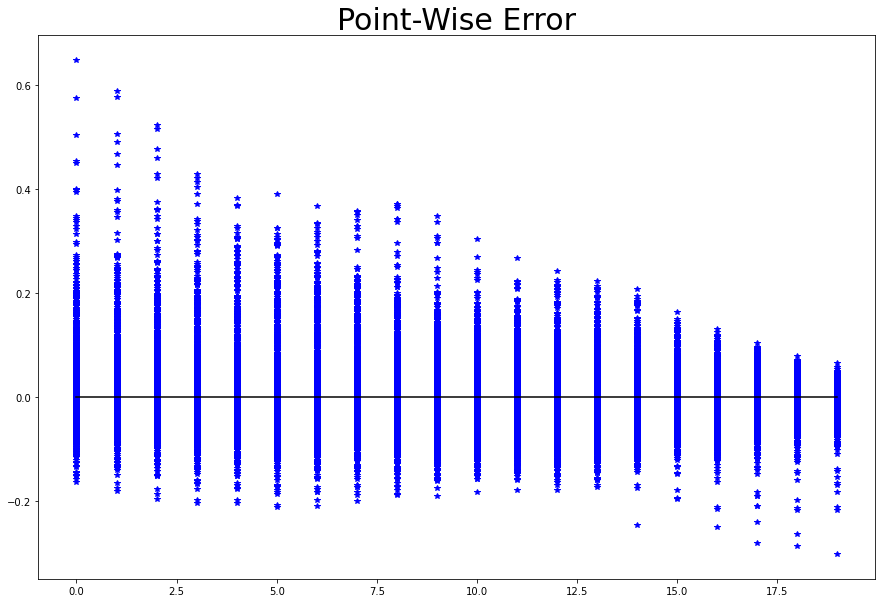

In [ ]:
# Run if you are splicing, if not spliced might be really hard to view
# Second Error graph - shows error for each point

predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(15, 10))
for i in range(len(x_valid)):
  plt.plot(y_valid[i] - y_pred[i], '*', color = 'b')
plt.plot([0, numOutputs - 1],[0,0], color = 'black')
plt.title('Point-Wise Error', fontsize = 30)
plt.savefig('PointWiseError.jpg')
plt.show()

In [ ]:
# DO NOT RUN UNLESS NEEDED - arithmetic not geometric graph
# Make Scatterplot Error graph with ARITHMETIC MEAN, blue is all networks, yellow is average

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictArithAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(10, 10), dpi=300)
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.5, color = 'b', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.5, color = 'y', label = 'Ensemble Network')
a, b = 0, .4 
plt.plot([a,b],[a,b], color='black')
plt.title('Symmetric Error Graph', fontsize = 20)
plt.xlabel('y actual', fontsize = 16)
plt.ylabel('y predicted', fontsize = 16)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
axe.text(.425, 0.4, f"R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
plt.savefig('SymErrorArith.jpg')
plt.show()

NameError: ignored

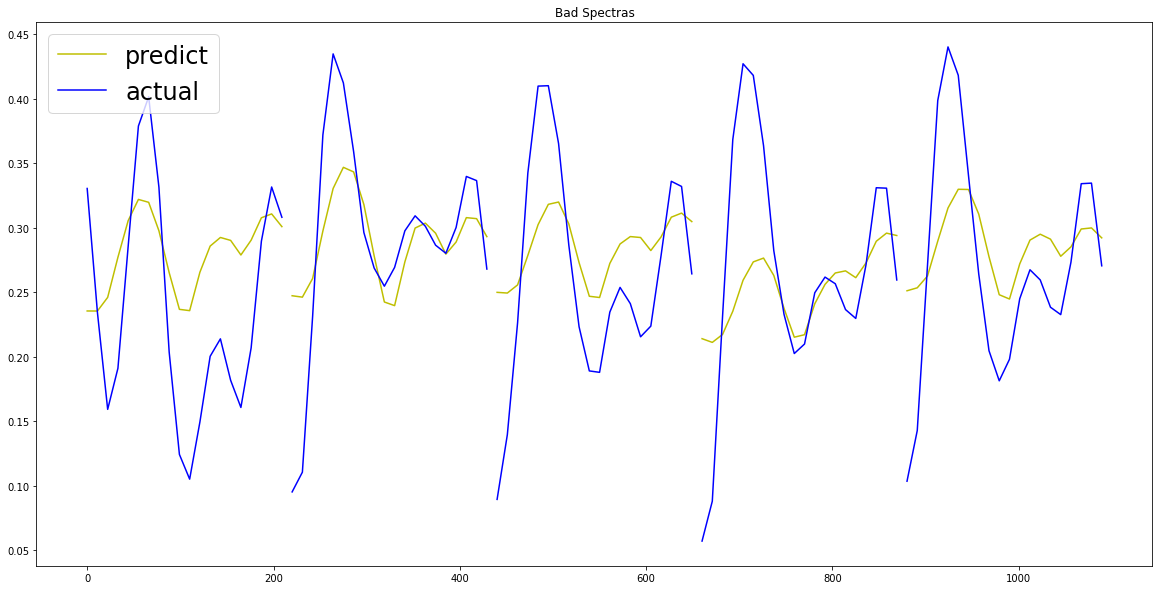

[[b'In.PM.AtFr', 23, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
----
[[b'In.PM.AtFr', 23, 1.0]]: 1
[[b'Lu.PM.AtFr', 31, 1.0]]: 4


In [ ]:
# DO NOT RUN UNLESS NEEDED - not really relevant anymore
# Puts out all very wavy spectra graphs and their associated information

bad = []
y = []
indexList = []
for i, ele in enumerate(y_valid):
  if max(ele) >= .4:
    bad.append(y_pred[i])
    y.append(ele)
    indexList.append(i)

x = np.array([x for x in range(0,220,splicingVal)])
fig = plt.figure(figsize=(20, 10))
#low, high = closest_factor(len(bad))

for j in range(10):
  for i in range(10):
    try:
      plt.plot(x + 220*i, bad[i+10*j]+.5*j, color = 'b')
      plt.plot(x + 220*i, y[i+10*j]+.5*j, color = 'y')
    except: 
      break
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 20})
plt.title('Bad Spectras', fontsize = 24)
plt.savefig('Bad.jpg')
plt.show()

def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList
  
def frequencyOfItems(arr):
  frequency = {}
  for item in arr:
    if str(item) in frequency:
        frequency[str(item)] += 1
    else:
        frequency[str(item)] = 1
  return frequency
iter = 0
oxideList = []
for index in indexList:
  metal = np.transpose(hf['atfrac'])[subsetSize + index][0:42]
  #print(iter, nonZeroInList(metal))
  oxideList.append(nonZeroInList(metal))
  iter += 1
sort = sorted(oxideList, key = lambda oxide: (oxide[0][1], len(oxide), oxide[0][2]))
for each in sort:
  print(each)
print('----')
for key, value in frequencyOfItems(sort).items():
  print(f'{key}: {value}')


In [ ]:
# Saving Code Block: uploads models under names to google drive, must move these to the Shared Drive

names = ['EpochOutput.txt', 'First10.jpg', 'Random10.jpg', 'ModelAccuracyMSLE.jpg', 'ModelAccuracyMAPE.jpg', 'PredictCompare.jpg', 'Bad.jpg', 'EverySpectra.jpg', 'SymErrorGeo.jpg', 'SymErrorArith.jpg', 'PointWiseError.jpg', 'MSE_Plot.jpg', 'Random100Grid.jpg', 'AllPredictions.jpg', 'Confidence.jpg', 'SDGraph.jpg', 'Histogram.jpg', 'AccuracyModel.jpg']
for name in names:
  try:
    colab_link = name
    gdrive_link = "/content/drive/My Drive/Colab Notebooks/Models"
    shutil.copy(colab_link, gdrive_link)
  except:
    print(f'{name} not downloaded')

EpochOutput.txt not downloaded
First10.jpg not downloaded
Random10.jpg not downloaded
ModelAccuracyMSLE.jpg not downloaded
ModelAccuracyMAPE.jpg not downloaded
Bad.jpg not downloaded
EverySpectra.jpg not downloaded
SymErrorArith.jpg not downloaded
MSE_Plot.jpg not downloaded
Random100Grid.jpg not downloaded
AllPredictions.jpg not downloaded
Histogram.jpg not downloaded


In [ ]:
# DO NOT RUN
# Just shows various error functions to use

y0 = y_test
predictList = makePredictionsList(modelList, x_test)
y1 = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]

dy = y0-y1 # error 
abs_dy = np.abs(y0-y1)    # absolute error 
relerr = np.abs(y0-y1)/y0   # relative error 
pererr = np.abs(y0-y1)/y0*100    # percentage error 
mean_err = np.mean(np.abs(y0-y1))     # mean absolute error 
MSE = np.mean((y0-y1)**2)        # Mean square error 
RMSE = np.sqrt(np.mean((y0-y1)**2))  # Root mean square error

In [ ]:
# DO NOT RUN
# Plots First 10 predictions all on the same graph
# Only use if you need to investigate oscillations in spectra graphs

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x, y[i] , color = 'y')    
  plt.legend(['predict'], loc='upper left')  
  plt.title('Combined First 10 Predictions', fontsize = 20)
plt.savefig('AllPredictions.jpg')
plt.show()

In [ ]:
# DO NOT RUN
# Attempt to implement Custom Loss Function, still a work in progress

def custom_loss(y_true, y_pred):
  #shape of y_true/y_pred = (batchSize, numOutputs)
  #distance metric
  lossDistance = tf.square(y_pred - y_true)
  return lossDistance
  #smoothness metric
  Deriv2 = 0
  for batch in range(batchSize):
    for i in range(numOutputs):
      if i == numOutputs - 3:
        break
      Deriv2 += 1

def SMU(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU_mu', shape=(),
                       initializer=tf.constant_initializer(1000000),
                       dtype=tf.float32)
    return ((1+alpha)*x + (1-alpha)*x*tf.math.erf(mu*(1-alpha)*x))/2

def SMU1(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU1_mu', shape=(),
                       initializer=tf.constant_initializer(4.352665993287951e-9),
                       dtype=tf.float32)
    return ((1+alpha)*x+tf.math.sqrt(tf.math.square(x-alpha*x)+tf.math.square(mu)))/2

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

#get_custom_objects().update({'SMU': Activation(SMU)}) 
#get_custom_objects().update({'SMU1': Activation(SMU1)}) 

In [ ]:
# DO NOT RUN 
# Use this only if we want to load an already built model
normal_model = load_model('Model.h5')

OSError: ignored

In [ ]:
# DO NOT RUN
# Attempted neural network for the outcomes of the ensemble, returned bad graphs so scratched for now, may implement later

def get_model_from_ensemble():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (numNetworks, numOutputs)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=20, activation='softsign')
    ])
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = [metrics.mean_squared_logarithmic_error, metrics.mean_absolute_percentage_error]))
    return model

# fixed input parameters
modelInput = makePredictionsList(modelList, x_train)
modelInput = np.transpose(modelInput, (1, 0, 2))

sys.stdout = open('EpochOutput2.txt', 'w') 
epochs = 50
batch_size = 64
x_train2, x_test2, y_train2, y_test2 = train_test_split(modelInput, spectra, test_size = 0.2, random_state = None)
final_model = get_model_from_ensemble()
final_history = final_model.fit(x_train2, y_train2, batch_size = batch_size,
              epochs = epochs, validation_data = (x_test2, y_test2), verbose = 1)
sys.stdout = terminal

# Plots to visualize the mean squared logarithmic error and mean absolute percentage error of our final neural network ensemble model

# MSLE
plt.plot(final_history.history['mean_squared_logarithmic_error'], label='MSLE training data')
plt.plot(final_history.history['val_mean_squared_logarithmic_error'], label='MSLE validation data')
plt.legend()
plt.title('Mean Squared Logarithmic Error Over Time')
plt.ylabel('MSLE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMSLE.jpg')
plt.show()

# MAPE
plt.plot(final_history.history['mean_absolute_percentage_error'], label='MAPE training data')
plt.plot(final_history.history['val_mean_absolute_percentage_error'], label='MAPE validation data')
plt.legend()
plt.title('Mean Absolute Percentage Error Over Time')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMAPE.jpg')
plt.show()